In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [4]:
# new dataset 
df_covid19.head(2)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active
0,Australia,2020-04-01 07:55:50,-25.0000,133.0000,4862,20,422,4420
1,Austria,2020-04-01 07:50:11,47.5162,14.5501,10298,128,1095,9075


In [5]:
df_confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,40,40,74,84,94,110,110,120,170,174
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,89,104,123,146,174,186,197,212,223,243


# Preprocessing 
<hr>

In [6]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [7]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [8]:
df_table = df_table[df_table["continent"] != "Others"]

In [9]:
df_deaths[df_deaths["continent" ]== 'Others']

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20
88,NaN,Diamond Princess,Others,0.000000,0.000000,0,0,0,0,0,...,8,8,10,10,10,10,10,10,10,10
127,NaN,Holy See,Others,41.902900,12.453400,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,NaN,Timor-Leste,Others,-8.874217,125.727539,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,NaN,West Bank and Gaza,Others,31.952200,35.233200,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
247,NaN,Kosovo,Others,42.602636,20.902977,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
248,NaN,Burma,Others,21.916200,95.956000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
252,NaN,MS Zaandam,Others,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# df_active = df_confirmed.copy()
# df_active.iloc[:,5:] = df_active.iloc[:,5:] - df_recovered.iloc[:,5:] - df_deaths.iloc[:,5:]
# df_active.head(5)

In [11]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
# df_recovered = df_recovered.replace(np.nan, '', regex=True)
# df_active = df_active.replace(np.nan, '', regex=True)

 # Defining Functions
 <hr>
* plot_params()
* visualize_covid_cases()
* get_mortality_rate()

In [12]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/Total_confirmed)*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""+"output/"

### Top 10 countries (Confirmed Cases and Deaths)

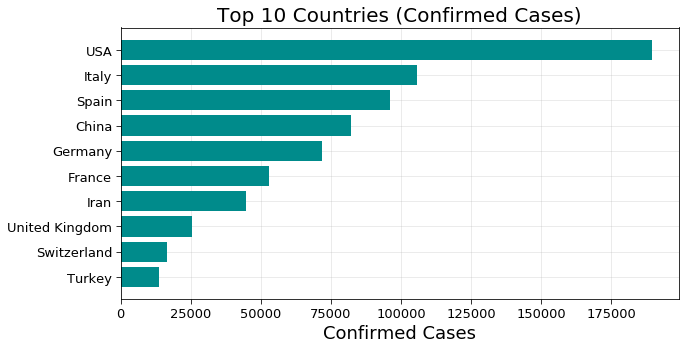

In [17]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Confirmed')["Confirmed"].index[-10:],df_countries_cases.sort_values('Confirmed')["Confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 Countries (Confirmed Cases).png')

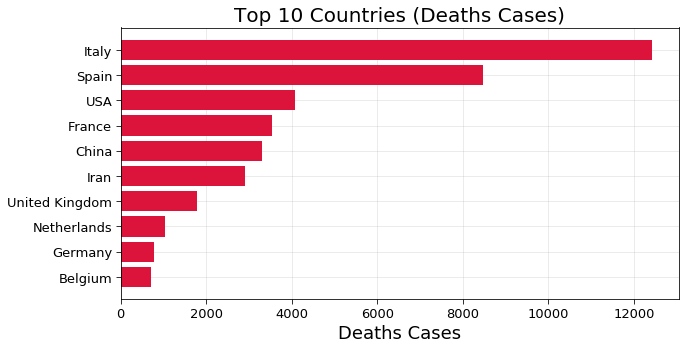

In [18]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Deaths')["Deaths"].index[-10:],df_countries_cases.sort_values('Deaths')["Deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths Cases",fontsize=18)
plt.title("Top 10 Countries (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Deaths Cases).png')

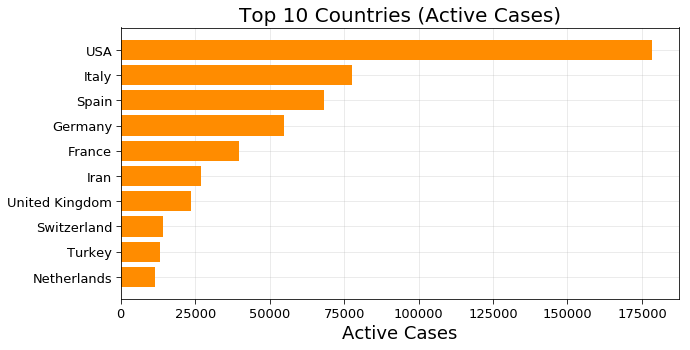

In [19]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Active')["Active"].index[-10:],df_countries_cases.sort_values('Active')["Active"].values[-10:],color="darkorange")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Active Cases",fontsize=18)
plt.title("Top 10 Countries (Active Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Active Cases).png')

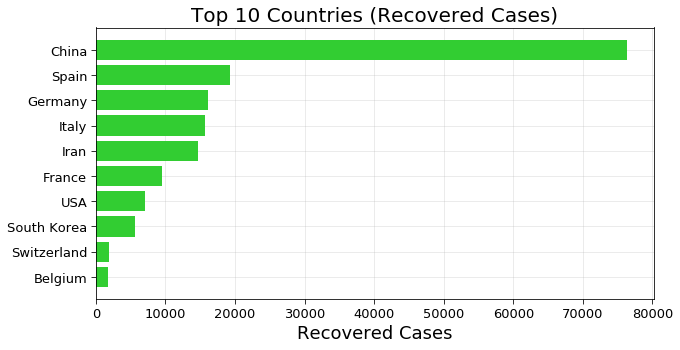

In [20]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_countries_cases.sort_values('Recovered')["Recovered"].index[-10:],df_countries_cases.sort_values('Recovered')["Recovered"].values[-10:],color="limegreen")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Recovered Cases",fontsize=18)
plt.title("Top 10 Countries (Recovered Cases)",fontsize=20)
plt.grid(alpha=0.3,which='both')
plt.savefig(out+'Top 10 Countries (Recovered Cases).png')

# Visualization on Map
<hr>

In [23]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['country']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['state']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(world_map)

world_map


# COVID-19 Spread Analysis
<hr>

Spread Analysis is in two sections 
1. Spread Across Globe
2. Spread Trends in the World, Continents and few most affected Countries

### 4. COVID-19 Spread Comparison of few most affected countries and INDIA

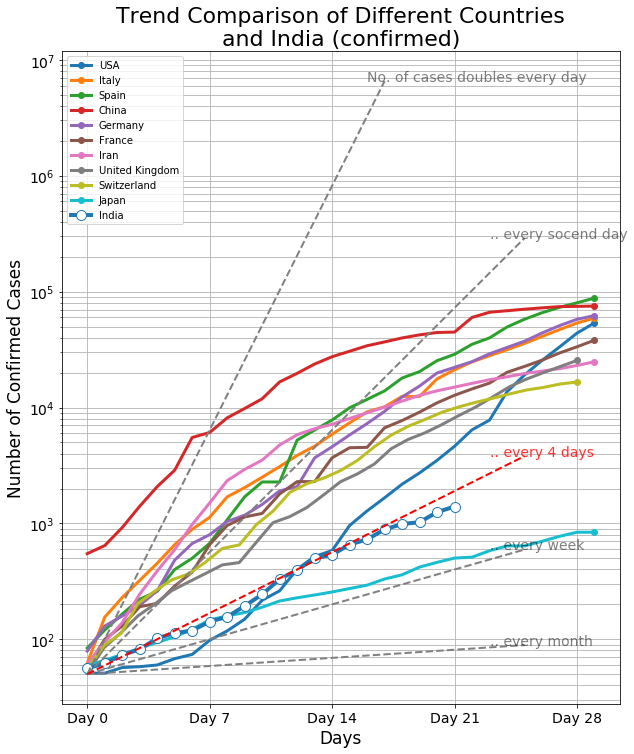

In [31]:
temp = df_confirmed.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 9:
        if country != "India" and country != "Japan" :
            continue
    x = 30
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:x]
     
    date = np.arange(0,len(t[:x]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    if country != "India":
        plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])
    else:
        marker_style = dict(linewidth=4, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')
        plt.plot(date,t,"-.",label = country,**marker_style)

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,30,7),[ "Day "+str(i) for i in range(30)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every socend day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = np.arange(0,26)
y = 2**(x/4+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. every 4 days",(x[-3],y[-1]),color="Red",xycoords="data",fontsize=14,alpha = 0.8)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Different Countries\n and India (confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison with India (confirmed).png')
plt.show()

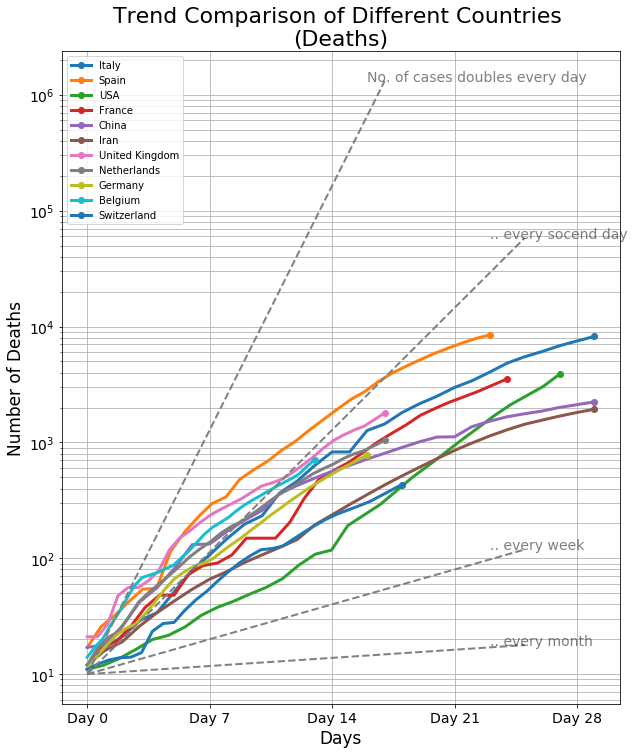

In [32]:
temp = df_deaths.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i > 10:
        break
    x = 30
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:x]
     
    date = np.arange(0,len(t[:x]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,30,7),[ "Day "+str(i) for i in range(30)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every socend day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Different Countries \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison countries deaths.png')
plt.show()

### 5. COVID-19 Spread Comparison of in different continents

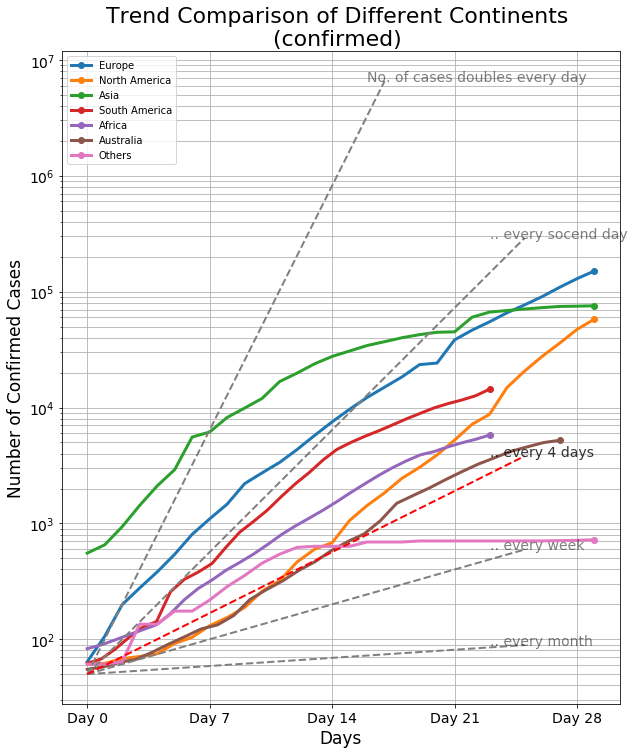

In [33]:
temp = df_confirmed.groupby('continent').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i > 10:
        break
    x = 30
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:x]
     
    date = np.arange(0,len(t[:x]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,30,7),[ "Day "+str(i) for i in range(30)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every socend day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = np.arange(0,26)
y = 2**(x/4+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. every 4 days",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.8)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Different Continents \n(confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison of continents (Confirmed).png')
plt.show()

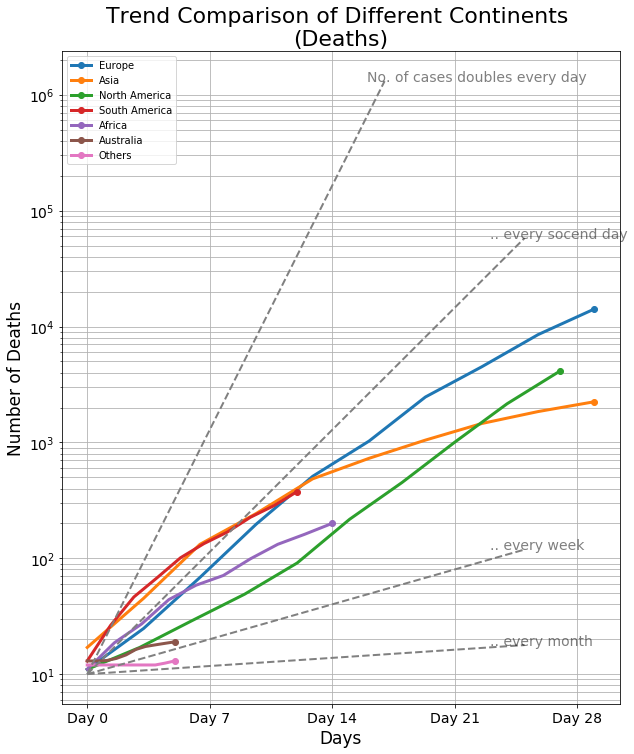

In [34]:
temp = df_deaths.groupby('continent').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i > 10:
        break
    x = 30
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:x]
     
    date = np.arange(0,len(t[:x]))
    xnew = np.linspace(date.min(), date.max(), 10)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,30,7),[ "Day "+str(i) for i in range(30)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every socend day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,26)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Different Continents \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison continents (deaths).png')
plt.show()

## Prediction Curve for Global Confirmed Cases
Buliding Model

In [37]:
data_y = np.log10(np.asarray(df_confirmed.sum()[5:]).astype("float32"))
data_x = np.arange(1,len(data_y)+1)

#### Loading Model

In [40]:
model = models.load_model("model_confirmed.h5")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0         
Total para

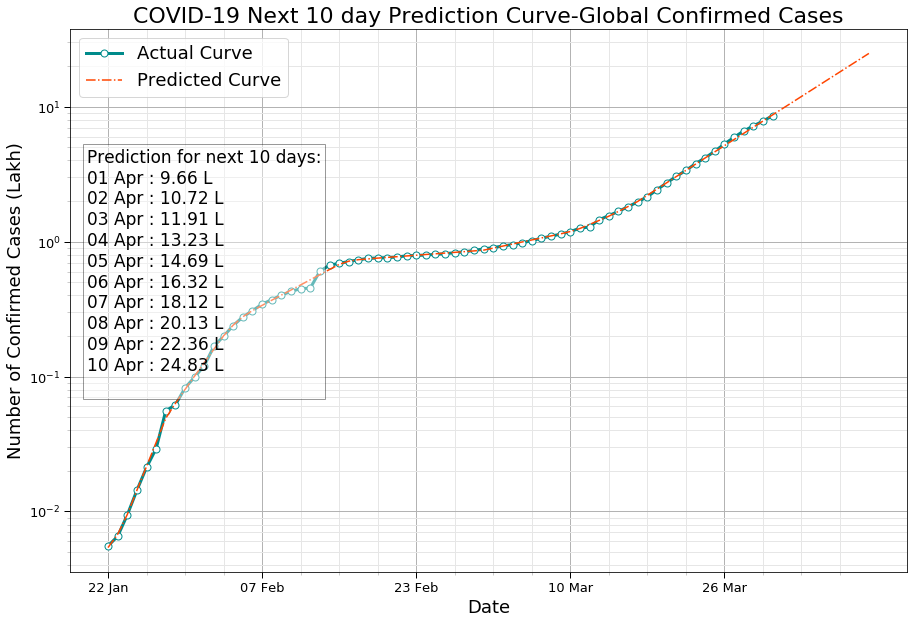

In [41]:
lakh = 100000
prediction_days = 10
data = np.power(10,model.predict(np.arange(1,len(data_y)+prediction_days+1)))
temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data/lakh,"-.",color="darkcyan",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data/lakh,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total = d + nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-3)[0]/lakh)+" L\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),d[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 10 day Prediction Curve-Global Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Confirmed Cases (Lakh)",fontsize =18)

plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve-Confirmed.png")
plt.show()

## Prediction Curve for Global Death Cases
Buliding Model

In [43]:
data1_y = np.log10(np.asarray(df_deaths.sum()[5:-1]).astype("float32"))
data1_x = np.arange(1,len(data_y))

#### Loading Model

In [46]:
model2 = models.load_model("model_deaths.h5")
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0         
Total para

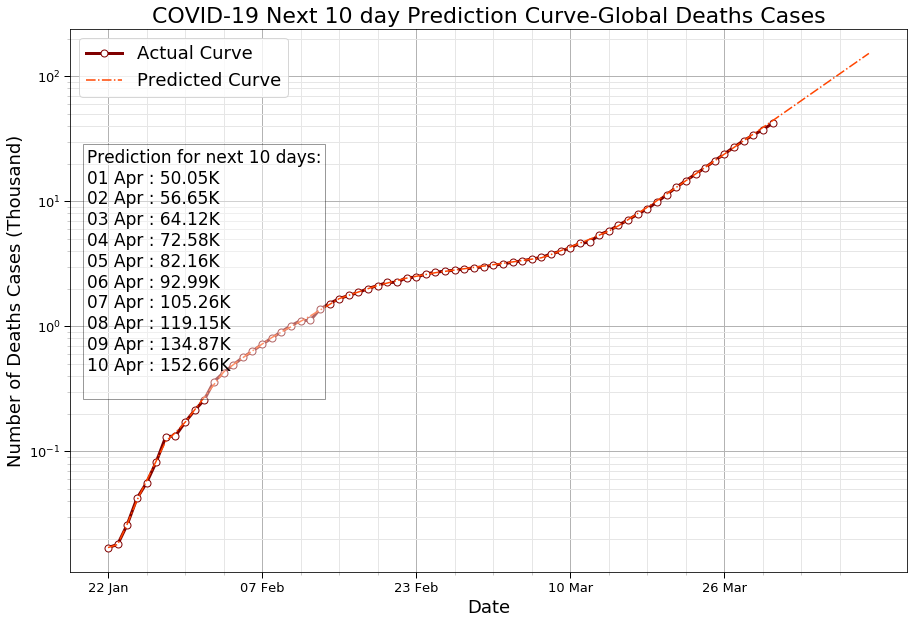

In [47]:
thousand = 1000
prediction_days = 10
data = np.power(10,model2.predict(np.arange(1,len(data_y)+prediction_days+1)))
temp_data = df_deaths.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))
# xnew = np.linspace(date.min(), date.max(), 10)
# spl = make_interp_spline(date, t, k=1)  # type: BSpline
# power_smooth = spl(xnew)

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data/thousand,"-.",color="maroon",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data/thousand,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-1)[0]/thousand)+"K\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 10 day Prediction Curve-Global Deaths Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Deaths Cases (Thousand)",fontsize =18)

plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve2.png")
plt.show()

### COVID-19: Change in Mortality Rate of Each Countries Over Time

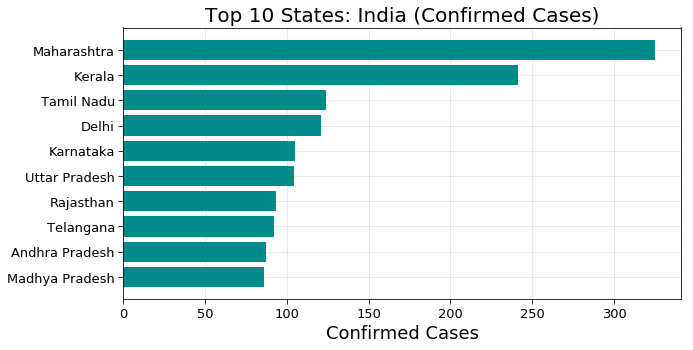

In [71]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 States_India (Confirmed Cases).png')

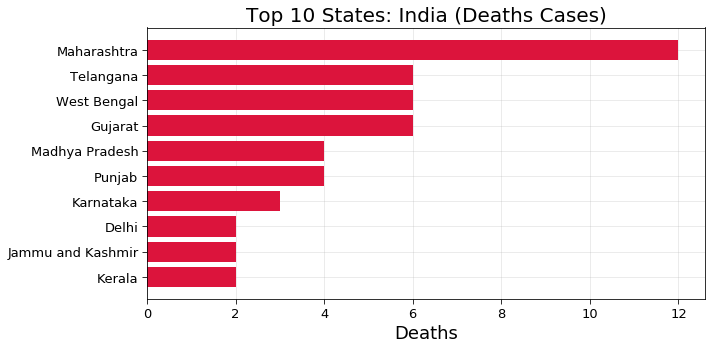

In [72]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig(out+'Top 10 States_India (Deaths Cases).png')

### Correlation

In [73]:
df_india.corr().style.background_gradient(cmap='Reds')

## Map Visualization (Statewise Inida)
<hr>

In [74]:
# Adding Location data (Latitude,Longitude)
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}
df_india["Lat"] = ""
df_india["Long"] = ""
for index in df_india.index :
    df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
    df_india.loc[df_india.index == index,"Long"] = locations[index][1]

In [75]:
# url = "https://raw.githubusercontent.com/Subhash9325/GeoJson-Data-of-Indian-States/master/Indian_States"
# state_json = requests.get(url).json()
india = folium.Map(location=[23,80], zoom_start=4,max_zoom=6,min_zoom=4,height=500,width="80%")
for i in range(0,len(df_india[df_india['confirmed']>0].index)):
    folium.Circle(
        location=[df_india.iloc[i]['Lat'], df_india.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_india.iloc[i].name+"</h5>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_india.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(df_india.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(df_india.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(df_india.iloc[i]['deaths'])+"</li>"+
        
        "<li>Mortality Rate:   "+str(np.round(df_india.iloc[i]['deaths']/(df_india.iloc[i]['confirmed']+1)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int(np.log2(df_india.iloc[i]['confirmed']+1)))*15000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(india)

india